#Load & Merge the Dataset


In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the datasets
heart_rate_non_linear_train = pd.read_csv('/content/drive/MyDrive/Updated_Dataset/heart_rate_non_linear_features_train.csv')
time_domain_train = pd.read_csv('/content/drive/MyDrive/Updated_Dataset/time_domain_features_train.csv')
frequency_domain_train = pd.read_csv('/content/drive/MyDrive/Updated_Dataset/frequency_domain_features_train.csv')


In [ ]:
# Convert 'datasetId' in heart_rate_non_linear_train and 'uuid' in other datasets to the same type
heart_rate_non_linear_train['datasetId'] = heart_rate_non_linear_train['datasetId'].astype(str)
time_domain_train['uuid'] = time_domain_train['uuid'].astype(str)
frequency_domain_train['uuid'] = frequency_domain_train['uuid'].astype(str)

In [ ]:
# Merge datasets on 'uuid'
train_data = pd.merge(heart_rate_non_linear_train, time_domain_train, on='uuid')
train_data = pd.merge(train_data, frequency_domain_train, on='uuid')

In [ ]:
# Drop unnecessary columns like 'uuid' and 'datasetId'
train_data.drop(columns=['uuid', 'datasetId'], inplace=True)

#Preprocess the data

In [ ]:
# Define mapping for conditions
condition_mapping = {
    'no stress': 0,
    'interruption': 1,
    'time pressure': 2
}

In [ ]:
# Create a new column 'condition_numeric' based on the mapping
train_data['condition_numeric'] = train_data['condition'].map(condition_mapping)

# Check the updated DataFrame
print(train_data[['condition', 'condition_numeric']].head())


      condition  condition_numeric
0     no stress                  0
1  interruption                  1
2  interruption                  1
3     no stress                  0
4     no stress                  0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Define features (X) and target (y)
X = train_data.drop(columns=['condition', 'condition_numeric', 'SD1'])  # Assuming SD1 is your target
y = train_data['SD1']  # Replace 'SD1' with the actual target column name if different

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM input (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Check shapes and types
print(X_train_reshaped.shape)
print(y_train.shape)
print(X_val_reshaped.shape)
print(y_val.shape)

(15999, 1, 33)
(15999,)
(4000, 1, 33)
(4000,)


#Build the RNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Build the RNN model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    Dense(1)  # Final layer for regression (single output for heart rate)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# View model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          16,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,851 (65.82 KB)

 Trainable params: 16,851 (65.82 KB)

 Non-trainable params: 0 (0.00 B)

#Train the RNN model

In [ ]:
# Train the model with smaller batch size
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=16, validation_data=(X_val_reshaped, y_val), verbose=1)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 47.6151 - val_loss: 2.4282
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3400 - val_loss: 0.6381
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.7304 - val_loss: 0.3357
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.3484 - val_loss: 0.1591
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.0210 - val_loss: 0.2287
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.6573 - val_loss: 0.1169
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5246 - val_loss: 0.0770
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3290 - val_loss: 0.0473
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1805 - val_loss: 0.0614
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0215 - val_loss: 0.0677
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9137 - val_loss: 0.0500
Epoch 12/100
1000/

#Evaluate the model


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions on validation data
y_pred = model.predict(X_val_reshaped)

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Print results
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error: 0.005696228687176047
Root Mean Squared Error: 0.07547336409075753
R² Score: 0.9993137981769189


#Making Predictions & Visualize using test data results

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the test datasets
heart_rate_non_linear_test = pd.read_csv('/content/drive/MyDrive/Updated_Dataset/heart_rate_non_linear_features_test.csv')
time_domain_test = pd.read_csv('/content/drive/MyDrive/Updated_Dataset/time_domain_features_test.csv')
frequency_domain_test = pd.read_csv('/content/drive/MyDrive/Updated_Dataset/frequency_domain_features_test.csv')

# Convert 'uuid' to the same type
heart_rate_non_linear_test['uuid'] = heart_rate_non_linear_test['uuid'].astype(str)
time_domain_test['uuid'] = time_domain_test['uuid'].astype(str)
frequency_domain_test['uuid'] = frequency_domain_test['uuid'].astype(str)

# Merge the test datasets on 'uuid'
test_data = pd.merge(heart_rate_non_linear_test, time_domain_test, on='uuid')
test_data = pd.merge(test_data, frequency_domain_test, on='uuid')

# Drop unnecessary columns like 'uuid', 'datasetId', and 'condition'
test_data.drop(columns=['uuid', 'datasetId', 'condition'], inplace=True)

# Drop the target variable 'SD1' from test data since it's not a feature
X_test = test_data.drop(columns=['SD1'], errors='ignore')  # Avoid error if 'SD1' is already missing

# Get the feature names used during training (assuming 'X' from training is available)
train_features = list(X.columns)

# Ensure only the features used during training are present in the test data
# If a feature from training is missing in the test data, fill it with zeros or an appropriate value
X_test = X_test.reindex(columns=train_features, fill_value=0)  # Fill missing columns with 0

# Use the same scaler that was fitted on the training data to scale the test data
X_test_scaled = scaler.transform(X_test)

# Extract the actual heart rate values from the test data (replace 'SD1' with your actual target column)
y_test_actual = heart_rate_non_linear_test['SD1']  # Replace 'SD1' with actual target column name if different

# Reshape the test data for LSTM input (samples, timesteps, features)
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Make predictions on the test data
y_test_pred = model.predict(X_test_reshaped)

# Convert predictions and actual values to a DataFrame for easy comparison
predictions_df = pd.DataFrame({
    'Actual Heart Rate': y_test_actual,  # Actual heart rate values
    'Predicted Heart Rate': y_test_pred.flatten()  # Predicted heart rate values (flattened for a 1D array)
})

# Print the predicted heart rate values and actual heart rate values
print(predictions_df)

# Optionally, save to CSV for further analysis
predictions_df.to_csv('/content/drive/MyDrive/Updated_Dataset/predictions.csv', index=False)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       Actual Heart Rate  Predicted Heart Rate
0               8.347898              9.308290
1              14.542096             14.846167
2               9.799336             10.152502
3              11.639185             11.836651
4               7.266567              8.770736
...                  ...                   ...
19994          11.459944             11.727113
19995          12.858976             13.125391
19996          15.969311             16.240120
19997           5.856104              7.564998
19998          11.182661             11.291671

[19999 rows x 2 columns]


#Data visualization

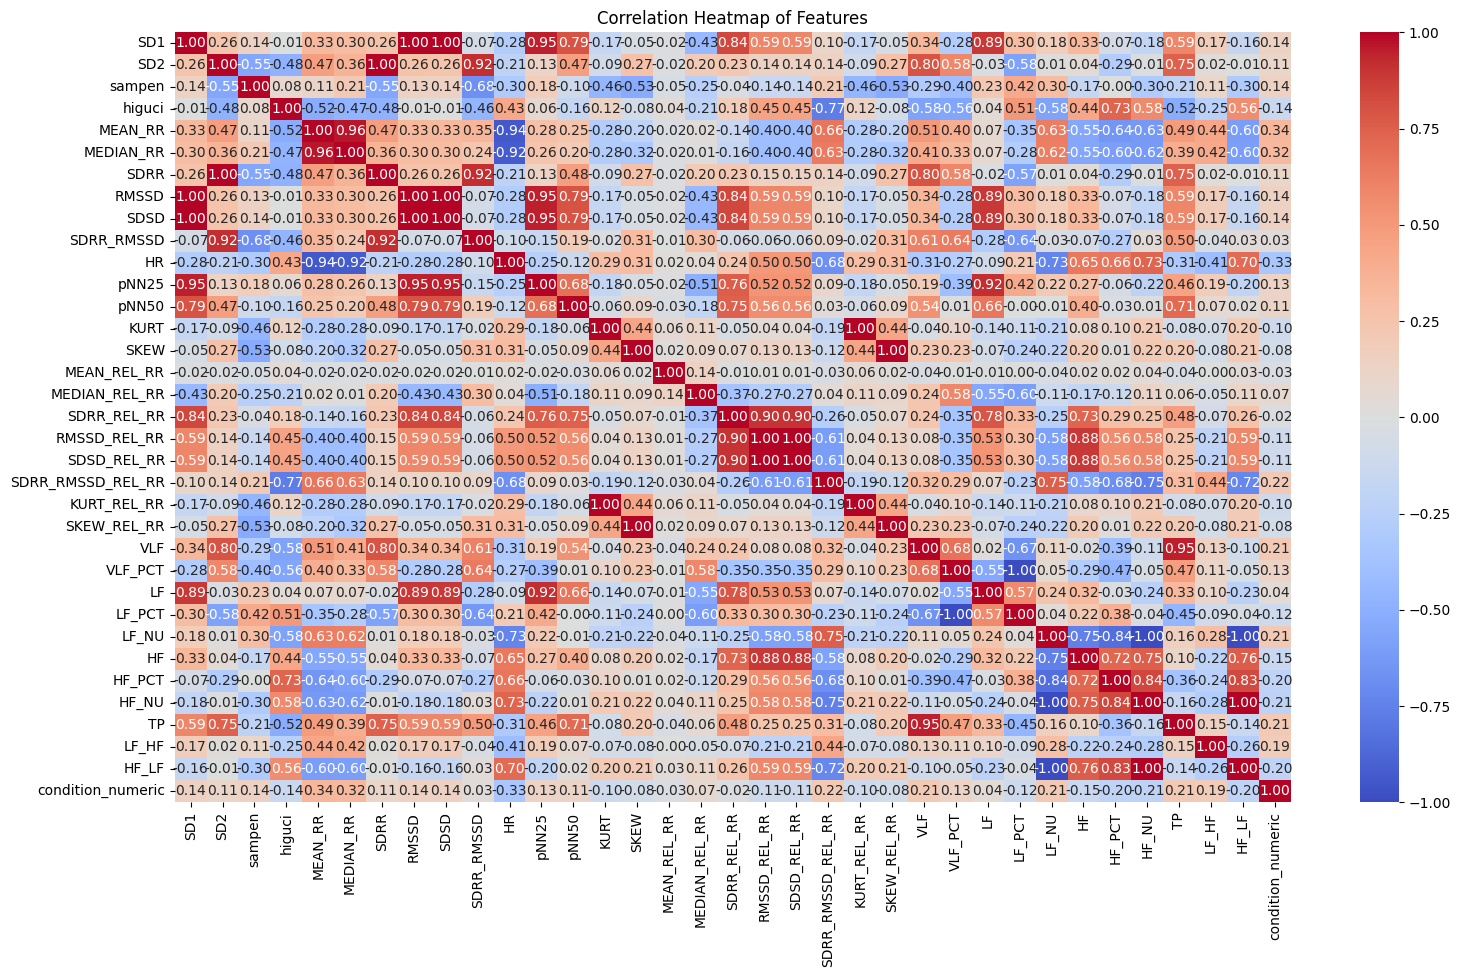

In [ ]:
# Drop non-numeric columns before generating the correlation matrix
numeric_data = train_data.drop(columns=['condition'])

# Correlation Heatmap
plt.figure(figsize=(18, 10))
correlation_matrix = numeric_data.corr()  # Only use numeric columns
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

<ipython-input-45-448cb5caf379>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='MEAN_RR', data=train_data, palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_gr

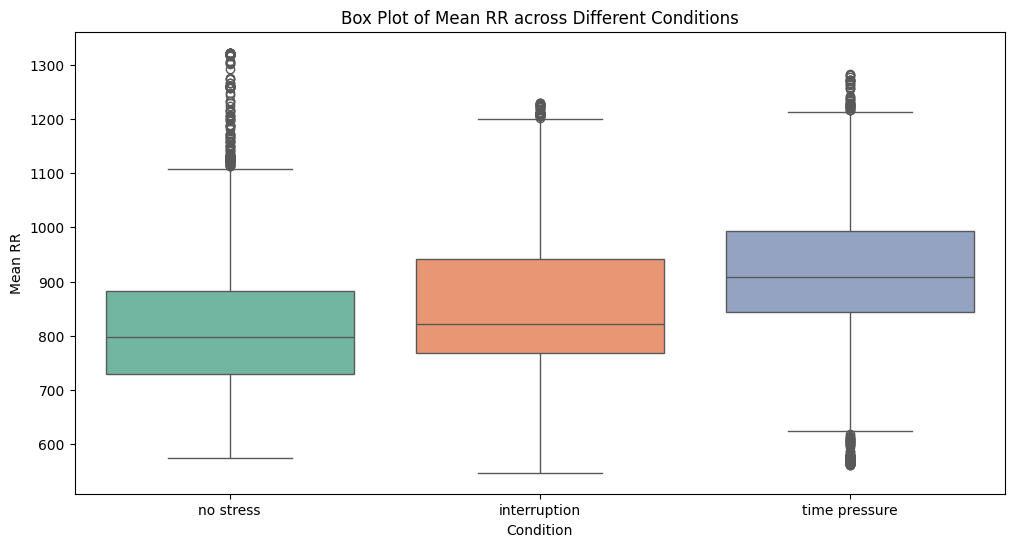

In [ ]:
# 3. Box Plot - Visualize the distribution of features across different conditions
plt.figure(figsize=(12, 6))
sns.boxplot(x='condition', y='MEAN_RR', data=train_data, palette='Set2')
plt.title('Box Plot of Mean RR across Different Conditions')
plt.xlabel('Condition')
plt.ylabel('Mean RR')
plt.show()

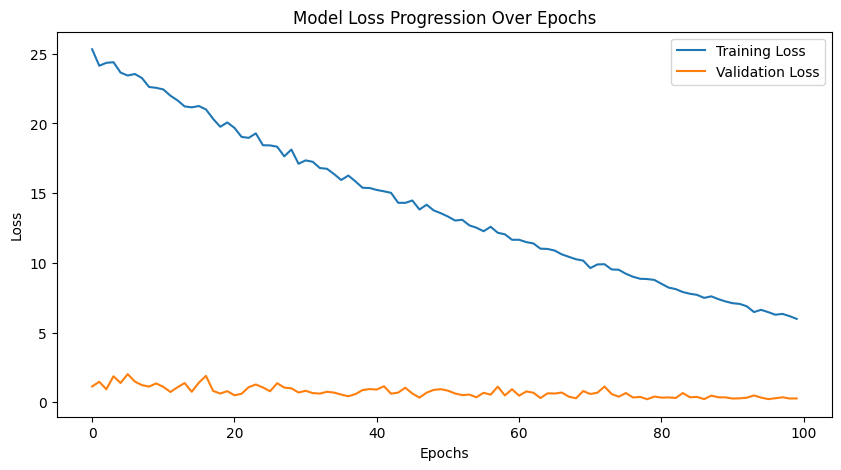

In [ ]:
# 4. Line Plot to show model loss progression over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()